<a href="https://colab.research.google.com/github/walt0923/face_restored/blob/main/pixel2pixel_%E5%B0%88%E9%A1%8C(%E5%B0%8Dskin%E5%81%9A%E8%99%95%E7%90%86).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **-----資料預處理-----**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


## 從雲端複製到本地

In [ ]:
import os, glob, random, shutil, re
from concurrent.futures import ThreadPoolExecutor, as_completed

# ====== 基本設定 ======
random.seed(42)

SRC_ROOT = '/content/drive/MyDrive/Special_Topic'
DST_ROOT = 'P2'
IMG_DIRNAME  = 'TRUE'
MASK_DIRNAME = 'FALSE'
DST_MASK_DIRNAME = 'FAKE'
PATTERN = '*.png'
MAX_WORKERS = 8    # 複製時的執行緒數
DEFAULT_QUOTA = 10   # 預設每類抽幾張（若無規則匹配）

EXACT_QUOTA = {
    'whitening': 1000,
    'smoothing': 1000,
    'facelifting': 1000,
    "eye": 1000,
    'three': 3000,
    'four': 3000,
}
# ====== 測試用 ======
# EXACT_QUOTA = {
#     'whitening': 10,
#     'smoothing': 10,
#     'facelifting': 10,
#     "eye": 10,
#     'three': 10,
#     'four': 10,
# }
REGEX_QUOTA = []

# ====== 工具函式 ======
def list_first_level_dirs(root):
    return sorted([d for d in os.listdir(root)
                   if os.path.isdir(os.path.join(root, d))])

def collect_pairs(img_folder, mask_folder, pattern):
    imgs  = {os.path.basename(p): p for p in glob.glob(os.path.join(img_folder, pattern))}
    masks = {os.path.basename(p): p for p in glob.glob(os.path.join(mask_folder, pattern))}
    common = sorted(set(imgs) & set(masks))
    return imgs, masks, common

def safe_copy(src, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    dst = os.path.join(dst_dir, os.path.basename(src))
    shutil.copyfile(src, dst)
    return dst

def quota_for(category_name: str) -> int:
    if category_name in EXACT_QUOTA:
        return EXACT_QUOTA[category_name]
    for pat, cnt in REGEX_QUOTA:
        if re.search(pat, category_name, flags=re.IGNORECASE):
            return cnt
    return DEFAULT_QUOTA

# ====== 主流程 ======
categories = list_first_level_dirs(SRC_ROOT)
if not categories:
    raise RuntimeError(f'來源資料夾沒有任何子資料夾：{SRC_ROOT}')

summary = {}

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futures = []

    for cat in categories:
        src_img_folder  = os.path.join(SRC_ROOT, cat, IMG_DIRNAME)
        src_mask_folder = os.path.join(SRC_ROOT, cat, MASK_DIRNAME)

        if not (os.path.isdir(src_img_folder) and os.path.isdir(src_mask_folder)):
            print(f'略過「{cat}」：找不到子資料夾 {IMG_DIRNAME}/ 或 {MASK_DIRNAME}/')
            continue

        imgs, masks, common = collect_pairs(src_img_folder, src_mask_folder, PATTERN)
        if len(common) == 0:
            print(f'略過「{cat}」：{IMG_DIRNAME} 與 {MASK_DIRNAME} 沒有共同檔名')
            continue

        quota = quota_for(cat)
        n = min(quota, len(common))
        chosen = random.sample(common, n)

        dst_img_folder  = os.path.join(DST_ROOT, cat, IMG_DIRNAME)
        dst_mask_folder = os.path.join(DST_ROOT, cat, DST_MASK_DIRNAME)
        os.makedirs(dst_img_folder, exist_ok=True)
        os.makedirs(dst_mask_folder, exist_ok=True)

        for name in chosen:
            futures.append(ex.submit(safe_copy, imgs[name],  dst_img_folder))
            futures.append(ex.submit(safe_copy, masks[name], dst_mask_folder))

        summary[cat] = n
        print(f'類別「{cat}」：規則目標 {quota} 張，可用 {len(common)} 張，實際抽 {n} 張')

    for _ in as_completed(futures):
        pass

# ====== 總結 ======
total_pairs = sum(summary.values())
print('====== 複製完成 ======')
for cat, cnt in summary.items():
    print(f'分類「{cat}」：{cnt} 對')
print(f'總計：{total_pairs} 對（影像與標註各 {total_pairs} 張）')
print(f'輸出根目錄：{os.path.abspath(DST_ROOT)}')


類別「eye」：規則目標 1000 張，可用 2577 張，實際抽 1000 張
類別「facelifting」：規則目標 1000 張，可用 5147 張，實際抽 1000 張
類別「four」：規則目標 3000 張，可用 4911 張，實際抽 3000 張
類別「smoothing」：規則目標 1000 張，可用 5147 張，實際抽 1000 張
類別「three」：規則目標 3000 張，可用 9969 張，實際抽 3000 張
類別「whitening」：規則目標 1000 張，可用 5147 張，實際抽 1000 張
====== 複製完成 ======
分類「eye」：1000 對
分類「facelifting」：1000 對
分類「four」：3000 對
分類「smoothing」：1000 對
分類「three」：3000 對
分類「whitening」：1000 對
總計：10000 對（影像與標註各 10000 張）
輸出根目錄：/content/P2


## 全部處理 ##

In [ ]:
import os
import cv2
import glob
import numpy as np

ROOT = 'P2'
IMG_DIR = 'TRUE'    # 原圖
FAKE_DIR = 'FAKE'   # 修圖
PATTERN = '*.png'
SIZE = (256, 256)

IMAGES  = []   # 原圖
IMAGES2 = []   # 修圖
CATS    = []   # 記錄每張圖屬於哪個類別
NAMES   = []   # 記錄檔名

def list_categories(root):
    return sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])

def collect_map(folder, pattern):
    return {os.path.basename(p): p for p in glob.glob(os.path.join(folder, pattern))}

for cat in list_categories(ROOT):
    before_dir = os.path.join(ROOT, cat, IMG_DIR)
    after_dir  = os.path.join(ROOT, cat, FAKE_DIR)

    if not (os.path.isdir(before_dir) and os.path.isdir(after_dir)):
        print(f'略過「{cat}」：找不到 {IMG_DIR}/ 或 {FAKE_DIR}/')
        continue

    imgs  = collect_map(before_dir, PATTERN)
    fakes = collect_map(after_dir,  PATTERN)

    common = sorted(set(imgs) & set(fakes))
    if not common:
        print(f'類別「{cat}」沒有同名成對檔案')
        continue

    for name in common:
        p_before = imgs[name]
        p_after  = fakes[name]

        before_img = cv2.imread(p_before)
        after_img  = cv2.imread(p_after)
        if before_img is None or after_img is None:
            print(f'讀取失敗（{cat}/{name}）')
            continue

        # 統一大小
        before_img = cv2.resize(before_img, SIZE)
        after_img  = cv2.resize(after_img,  SIZE)

        IMAGES.append(before_img)
        IMAGES2.append(after_img)
        CATS.append(cat)
        NAMES.append(name)

IMAGES  = np.array(IMAGES)
IMAGES2 = np.array(IMAGES2)

print(f'收集完成：{len(IMAGES)} 對')


收集完成：10000 對


In [ ]:
# import random

# # 隨機抽 5 張來檢查
# num_samples = 5
# indices = random.sample(range(len(IMAGES)), num_samples)

# plt.figure(figsize=(10, num_samples*2))
# for i, idx in enumerate(indices):
#     # BGR -> RGB
#     before_img = cv2.cvtColor(IMAGES[idx], cv2.COLOR_BGR2RGB)
#     after_img  = cv2.cvtColor(IMAGES2[idx], cv2.COLOR_BGR2RGB)

#     # 左邊原圖, 右邊修圖
#     plt.subplot(num_samples, 2, 2*i+1)
#     plt.imshow(before_img)
#     plt.title(f"TRUE idx={idx}")
#     plt.axis("off")

#     plt.subplot(num_samples, 2, 2*i+2)
#     plt.imshow(after_img)
#     plt.title(f"FAKE idx={idx}")
#     plt.axis("off")

# plt.tight_layout()
# plt.show()


# **-----重製環境-----**

In [ ]:
%reset -f

import gc
gc.collect()

try:
    import torch
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
except Exception as e:
    print("GPU cleanup skipped:", e)


In [ ]:
import torch
torch.autograd.set_detect_anomaly(True)


# **-----開始訓練模型-----**

In [ ]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.backends.cudnn.benchmark = True # 在訓練開始前開啟

# ---**model部分**---

# **model**

In [ ]:
import functools
import torch
import torch.nn as nn
import torch.nn.functional as F


# =======================
# pixel2pixel
# =======================
class Generator(nn.Module):
    def __init__(self, in_num_ch=3, out_num_ch=3, first_num_ch=32, input_size=256): # 32
        super(Generator, self).__init__()

        self.down_1 = nn.Sequential(
            nn.Conv2d(in_num_ch, first_num_ch, 4, 2, padding=1),
            nn.LeakyReLU(0.2)
        )
        self.down_2 = ConvBlock(first_num_ch, 2*first_num_ch)
        self.down_3 = ConvBlock(2*first_num_ch, 4*first_num_ch)
        self.down_4 = ConvBlock(4*first_num_ch, 8*first_num_ch)
        self.down_5 = ConvBlock(8*first_num_ch, 8*first_num_ch)
        self.down_6 = ConvBlock(8*first_num_ch, 8*first_num_ch, activation='no')


        self.bottleneck = nn.Sequential(
            ResBlock(8*first_num_ch, dilation=1),
            ResBlock(8*first_num_ch, dilation=2),
            ResBlock(8*first_num_ch, dilation=3),
            ResBlock(8*first_num_ch, dilation=1),
        )


        self.up_5 = DeconvBlock(8*first_num_ch, 8*first_num_ch)
        self.up_4 = DeconvBlock(16*first_num_ch, 8*first_num_ch)
        self.up_3 = DeconvBlock(16*first_num_ch, 4*first_num_ch)
        self.up_2 = DeconvBlock(8*first_num_ch, 2*first_num_ch)
        self.up_1 = DeconvBlock(4*first_num_ch, first_num_ch)

        self.output = DeconvBlock(2*first_num_ch, out_num_ch, is_last=True)
        self.output_act = nn.Tanh()
        # self.output_act = nn.Sigmoid()


    def forward(self, x):
        down_1 = self.down_1(x)
        down_2 = self.down_2(down_1)
        down_3 = self.down_3(down_2)
        down_4 = self.down_4(down_3)
        down_5 = self.down_5(down_4)
        down_6 = self.down_6(down_5)


        d = self.bottleneck(down_6)

        up_5 = self.up_5(down_5, d)
        up_4 = self.up_4(down_4, up_5)
        up_3 = self.up_3(down_3, up_4)
        up_2 = self.up_2(down_2, up_3)
        up_1 = self.up_1(down_1, up_2)
        output = self.output(None, up_1)
        output_act = self.output_act(output)
        return output_act

class ConvBlock(nn.Module):
    def __init__(self, in_num_ch, out_num_ch, filter_size=4, stride=2, padding=1, activation='lrelu', norm='in'):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_num_ch, out_num_ch, filter_size, stride, padding=padding),
            )
        if norm == 'bn':
            self.act = nn.BatchNorm2d(out_num_ch)
        elif norm == 'in':
            self.act = nn.InstanceNorm2d(out_num_ch, affine=True)

        if activation == 'lrelu':
            self.act2 = nn.LeakyReLU(0.2)
        else:
            self.act2 = nn.Sequential()

    def forward(self, x):
        x = self.conv(x)
        x = self.act(x)
        x = self.act2(x)
        return x

class ResBlock(nn.Module):
    def __init__(self, ch, dilation=1, norm='in'):
        super().__init__()
        pad = dilation
        layers = [
            nn.Conv2d(ch, ch, 3, 1, padding=pad, dilation=dilation, bias=(norm is None)),
            nn.InstanceNorm2d(ch, affine=True) if norm=='in' else nn.BatchNorm2d(ch),
            nn.ReLU(),
            nn.Conv2d(ch, ch, 3, 1, padding=pad, dilation=dilation, bias=(norm is None)),
            nn.InstanceNorm2d(ch, affine=True) if norm=='in' else nn.BatchNorm2d(ch),
        ]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return F.relu(x + self.block(x))

class DeconvBlock(nn.Module):
    def __init__(self, in_num_ch, out_num_ch, filter_size=3, stride=1, padding=1,
                 activation='lrelu', norm='in', is_last=False):
        super(DeconvBlock, self).__init__()

        if activation == 'lrelu':
            self.act = nn.LeakyReLU(0.2)
        elif activation == 'relu':
            self.act = nn.ReLU()
        else:
            self.act = nn.Sequential()

        self.is_last = is_last

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_num_ch, out_num_ch, filter_size, stride, padding=padding)
        )

        if not is_last:
            self.bn = nn.InstanceNorm2d(out_num_ch, affine=True) if norm == 'in' else nn.BatchNorm2d(out_num_ch)

    def forward(self, x_down, x_up):
        x_up = self.act(x_up)
        x_up = self.up(x_up)

        if not self.is_last:
            x_up = self.bn(x_up)
            x = torch.cat([x_down, x_up], 1)
        else:
            x = x_up

        return x

# =======================
# Discriminator
# =======================
class Discriminator(nn.Module):
    def __init__(self, in_num_ch=6, first_num_ch=32):
        super(Discriminator, self).__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_num_ch, first_num_ch, 4, 2, padding=1),
            nn.LeakyReLU(0.2)
        )
        self.conv_2 = ConvBlock(first_num_ch, 2 * first_num_ch, norm='in')
        self.conv_3 = ConvBlock(2 * first_num_ch, 4 * first_num_ch, norm='in')
        self.conv_4 = ConvBlock(4 * first_num_ch, 8 * first_num_ch, norm='in')
        self.conv_5 = ConvBlock(8 * first_num_ch, 8 * first_num_ch, stride=1)

        self.output = nn.Conv2d(8 * first_num_ch, 1, 4)
        self.output_act = nn.Sigmoid()

    def forward(self, x, return_feats=False):
        conv_1 = self.conv_1(x)
        conv_2 = self.conv_2(conv_1)
        conv_3 = self.conv_3(conv_2)
        conv_4 = self.conv_4(conv_3)
        conv_5 = self.conv_5(conv_4)

        output = self.output(conv_5)
        # output = self.output_act(output) # 保持原樣 (LSGAN 不用 Sigmoid)

        if return_feats:
            return output, [conv_1, conv_2, conv_3, conv_4, conv_5]
        else:
            return output

# =======================
# CBAM
# =======================
class CBAM(nn.Module):

    def __init__(self, n_channels_in, reduction_ratio, kernel_size):
        super(CBAM, self).__init__()
        self.n_channels_in = n_channels_in
        self.reduction_ratio = reduction_ratio
        self.kernel_size = kernel_size

        self.channel_attention = ChannelAttention(n_channels_in, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, f):
        chan_att = self.channel_attention(f)
        # print(chan_att.size())
        fp = chan_att * f
        # print(fp.size())
        spat_att = self.spatial_attention(fp)
        # print(spat_att.size())
        fpp = spat_att * fp
        # print(fpp.size())
        return fpp


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        assert kernel_size % 2 == 1, "Odd kernel size required"
        self.conv = nn.Conv2d(in_channels = 2, out_channels = 1, kernel_size = kernel_size, padding= int((kernel_size-1)/2))


    def forward(self, x):
        max_pool, _ = torch.max(x, dim = 1, keepdim = True)
        avg_pool = torch.mean(x, dim = 1, keepdim = True)
        pool = torch.cat([max_pool, avg_pool], dim = 1)
        conv = self.conv(pool)
        att = torch.sigmoid(conv)

        return att

class ChannelAttention(nn.Module):
    def __init__(self, n_channels_in, reduction_ratio):
        super().__init__()
        c = n_channels_in
        r = max(1, int(c / float(reduction_ratio)))

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.mlp = nn.Sequential(
            nn.Conv2d(c, r, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(r, c, kernel_size=1, bias=False),
        )

    def forward(self, x):
        att = self.mlp(self.avg_pool(x)) + self.mlp(self.max_pool(x))  # (B,C,1,1)
        return torch.sigmoid(att)

# =======================
# RRDB
# =======================
def make_layer(block, n_layers):
    return nn.Sequential(*[block() for _ in range(n_layers)])

class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=32, gc=32, bias=True):
        super().__init__()
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2*gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3*gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4*gc, nf, 3, 1, 1, bias=bias)
        self.cbma = CBAM(nf, 8, 5)

        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat([x, x1], 1)))
        x3 = self.lrelu(self.conv3(torch.cat([x, x1, x2], 1)))
        x4 = self.lrelu(self.conv4(torch.cat([x, x1, x2, x3], 1)))
        x5 = self.conv5(torch.cat([x, x1, x2, x3, x4], 1))
        x5 = self.cbma(x5)
        return x + 0.2 * x5

class RRDB(nn.Module):
    def __init__(self, nf, gc=32):
        super().__init__()
        self.b1 = ResidualDenseBlock_5C(nf, gc)
        self.b2 = ResidualDenseBlock_5C(nf, gc)
        self.b3 = ResidualDenseBlock_5C(nf, gc)
    def forward(self, x):
        return x + 0.2 * self.b3(self.b2(self.b1(x)))

class RRDBRefineNet(nn.Module):

    def __init__(self, in_nc=6, out_nc=3, nf=32, nb=3, gc=32):
        super().__init__()
        RRDB_block = functools.partial(RRDB, nf=nf, gc=gc)
        self.head = nn.Conv2d(in_nc, nf, 3, 1, 1)
        self.trunk = make_layer(RRDB_block, nb)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1)
        self.tail = nn.Conv2d(nf, out_nc, 3, 1, 1)
    def forward(self, x, y_coarse):
        inp = torch.cat([x, y_coarse], dim=1)
        fea = self.head(inp)
        trunk = self.trunk_conv(self.trunk(fea))
        fea = fea + trunk
        r = self.tail(fea)
        y_hat = (y_coarse + r).clamp(-1, 1)
        return y_hat, r

# **loss part1**

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models

# =======================
# PerceptualLoss
# =======================
class PerceptualLoss(nn.Module):
    '''
    content loss and style loss extracted by selected model
    '''
    def __init__(self, device, model_type='vgg19', content_layers=['conv_2', 'conv_3'],
                style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'], channel_idx=0):
        super(PerceptualLoss, self).__init__()
        self.device = device
        self.model_type = model_type
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.channel_idx = channel_idx

        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features
        for i, m in enumerate(vgg):
            if isinstance(m, nn.ReLU):
                vgg[i] = nn.ReLU(inplace=False)
        self.model = vgg.to(device).eval()
        for p in self.model.parameters():
            p.requires_grad = False

    def normalize_image(self, image):
        # [-1,1] (tanh 輸出) → [0,1]
        image = (image + 1) / 2
        image = image.clamp(0, 1)
        # # grayscale to rgb
        # image = image[:, self.channel_idx, :, :]
        # image = image.unsqueeze(1).expand(-1, 3, -1, -1)

        # normalize by mean/std
        mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(self.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(self.device)


        # resize 到 224x224
        if image.shape[-2:] != (224, 224):
            image = F.interpolate(image, size=(224, 224), mode='bilinear', align_corners=False)

        # ImageNet normalize
        image = (image - mean) / std
        return image

    def content_loss(self, feature_prediction, feature_target):
        content_loss = F.mse_loss(feature_prediction, feature_target)

        return content_loss

    def style_loss(self, feature_prediction, feature_target):
        gram_prediction = self.gram_matrix(feature_prediction)
        gram_target = self.gram_matrix(feature_target)
        style_loss = F.mse_loss(gram_prediction, gram_target)

        return style_loss

    def gram_matrix(self, feat):
        b, c, h, w = feat.size()
        f = feat.view(b, c, h*w)
        G = torch.bmm(f, f.transpose(1, 2))
        return G / (c*h*w)

    # 不使用
    # def gram_matrix(self, feature):
    #     batch_size, num_ch, height, width = feature.size()  # NCHW
    #     feature = feature.view(batch_size * num_ch, height * width)
    #     gram = torch.mm(feature, feature.t())

    #     return gram.div(batch_size * num_ch * height * width)

    def forward(self, prediction, target):
        prediction = self.normalize_image(prediction)
        target = self.normalize_image(target)

        conv_block_idx = 0
        model_new = nn.Sequential().to(self.device)
        content_losses = []
        # style_losses = []
        feature_prediction = prediction
        feature_target = target

        for i, layer in enumerate(self.model):
            feature_prediction = layer(feature_prediction)
            feature_target = layer(feature_target)
            if isinstance(layer, nn.Conv2d):
                conv_block_idx += 1
                name = 'conv_' + str(conv_block_idx)
                if name in self.content_layers:
                    content_losses.append(self.content_loss(feature_prediction, feature_target))
                # if name in self.style_layers:
                #     style_losses.append(self.style_loss(feature_prediction, feature_target))

        return content_losses


# **loss part2**

In [ ]:
!pip install lpips


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# =======================
# GANLoss
# =======================
class GANLoss(nn.Module):
    def __init__(self, device, ls_gan=True):
        super(GANLoss, self).__init__()
        self.device = device
        if ls_gan == True:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def forward(self, prediction, target_label_value=1.):
        target_label = torch.tensor(target_label_value).to(self.device)
        target = target_label.expand_as(prediction)
        loss = self.loss(prediction, target)
        return loss

class ResidualLoss(nn.Module):
    """
    Residual Loss for Stage-2 Refiner
    r       : residual predicted by G2
    y_hat   : refined output = y_coarse + r
    y       : ground truth (target image)
    y_coarse: coarse output from G1
    """
    def __init__(self, criterion=nn.L1Loss()):
        super(ResidualLoss, self).__init__()
        self.criterion = criterion

    def forward(self, r, y_hat, y, y_coarse):
        r_gt = (y - y_coarse).detach()
        l_res = self.criterion(r, r_gt)

        l_l1  = self.criterion(y_hat, y)
        return l_res, l_l1

class SobelEdgeLoss(nn.Module):
    def __init__(self, mode='mag', loss='l1', eps=1e-6):
        """
        mode: 'mag' | 'xy'    # 比較梯度幅值或同時比較 Gx/Gy
        loss: 'l1' | 'charb'  # L1 或 Charbonnier
        """
        super().__init__()
        self.mode, self.loss, self.eps = mode, loss, eps
        kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=torch.float32).view(1,1,3,3)
        ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=torch.float32).view(1,1,3,3)
        self.register_buffer('kx', kx)
        self.register_buffer('ky', ky)

    def _grad(self, x):
        c = x.size(1)
        kx = self.kx.repeat(c,1,1,1)
        ky = self.ky.repeat(c,1,1,1)
        gx = F.conv2d(x, kx, padding=1, groups=c)
        gy = F.conv2d(x, ky, padding=1, groups=c)
        if self.mode == 'xy':
            return gx, gy
        # 幅值
        mag = torch.sqrt(gx*gx + gy*gy + self.eps)
        return mag

    def _l(self, a, b):
        if self.loss == 'l1':
            return F.l1_loss(a, b)
        return torch.mean(torch.sqrt((a-b)**2 + self.eps))

    def forward(self, out, gt):
        # out, gt: (N,C,H,W)，範圍 [-1,1] 或 [0,1] 都可（兩邊一致即可）
        if self.mode == 'xy':
            gx_o, gy_o = self._grad(out)
            gx_g, gy_g = self._grad(gt)
            return 0.5 * (self._l(gx_o, gx_g) + self._l(gy_o, gy_g))
        else:
            mag_o = self._grad(out)
            mag_g = self._grad(gt)
            return self._l(mag_o, mag_g)

class LaplacianEdgeLoss(nn.Module):
    def __init__(self, loss='l1'):
        super().__init__()
        self.loss = loss
        k = torch.tensor([[0,1,0],[1,-4,1],[0,1,0]], dtype=torch.float32).view(1,1,3,3)
        self.register_buffer('k', k)

    def _l(self, a, b):
        if self.loss == 'l1':
            return F.l1_loss(a,b)
        return torch.mean(torch.sqrt((a-b)**2 + 1e-6))

    def forward(self, out, gt):
        c = out.size(1)
        k = self.k.repeat(c,1,1,1)
        lo = F.conv2d(out, k, padding=1, groups=c)
        lg = F.conv2d(gt,  k, padding=1, groups=c)
        return self._l(lo, lg)

def feature_matching_loss(feats_fake, feats_real):
    return sum(F.l1_loss(f_fake, f_real.detach()) for f_fake, f_real in zip(feats_fake, feats_real))

def fft_highfreq_loss(pred, target, hp_ratio=0.5):
    # pred/target: (N,C,H,W), [-1,1] or [0,1] (一致即可)
    N, C, H, W = pred.shape
    P = torch.fft.rfft2(pred, norm='ortho')
    T = torch.fft.rfft2(target, norm='ortho')

    # 建立高頻權重遮罩（以半徑比 hp_ratio 作為分界）
    yy, xx = torch.meshgrid(torch.arange(H, device=pred.device),
                            torch.arange(W//2+1, device=pred.device), indexing='ij')
    cy, cx = H//2, 0
    r = torch.sqrt(((yy-cy)/(H/2))**2 + ((xx-cx)/(W/2))**2)  # 0~1
    w = torch.clamp((r - hp_ratio) / (1 - hp_ratio), 0, 1)   # 低頻0→高頻1
    w = w.view(1,1,H,W//2+1)

    loss = torch.mean(torch.abs(P - T) * w)
    return loss


In [ ]:
# class PSNRLoss(nn.Module):

#     def __init__(self, loss_weight=1.0, reduction='mean', toY=False):
#         super(PSNRLoss, self).__init__()
#         assert reduction == 'mean'
#         self.loss_weight = loss_weight
#         self.scale = 10 / np.log(10)
#         self.toY = toY
#         self.coef = torch.tensor([65.481, 128.553, 24.966]).reshape(1, 3, 1, 1)
#         self.first = True

#     def forward(self, pred, target):
#         assert len(pred.size()) == 4
#         if self.toY:
#             if self.first:
#                 self.coef = self.coef.to(pred.device)
#                 self.first = False

#             pred = (pred * self.coef).sum(dim=1).unsqueeze(dim=1) + 16.
#             target = (target * self.coef).sum(dim=1).unsqueeze(dim=1) + 16.

#             pred, target = pred / 255., target / 255.
#             pass
#         assert len(pred.size()) == 4

#         return self.loss_weight * self.scale * torch.log(((pred - target) ** 2).mean(dim=(1, 2, 3)) + 1e-8).mean()

# class DSSIMLoss(nn.Module):
#     '''
#     DSSIM is structural dissimilarity metric.
#     DSSIM = (1 - SSIM) / 2

#     Assume the input shape is NCHW
#     '''
#     def __init__(self, kernel_size=7, stride=3, value_range=1.):
#         super(DSSIMLoss, self).__init__()
#         self.kernel_size = kernel_size
#         self.stride = stride
#         self.value_range = value_range

#     def extract_patches(self, prediction, target):
#         # extract patches from NCHW to N * kernel_size * kernel_size * #patches
#         batch_size = prediction.shape[0]
#         patches_prediction = prediction.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
#         patches_prediction = patches_prediction.contiguous().view(batch_size, -1, self.kernel_size, self.kernel_size).permute(0,2,3,1)
#         patches_target = prediction.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
#         patches_target = patches_target.contiguous().view(batch_size, -1, self.kernel_size, self.kernel_size).permute(0,2,3,1)
#         return patches_prediction, patches_target

#     def forward(self, prediction, target):
#         # parameters
#         k1 = 0.01
#         k2 = 0.03

#         # get patches
#         patches_prediction, patches_target = self.extract_patches(prediction, target)

#         # compute SSIM
#         c1 = (k1 * self.value_range) ** 2
#         c2 = (k2 * self.value_range) ** 2
#         ux = patches_prediction.mean(-1)
#         uy = patches_target.mean(-1)
#         vx = patches_prediction.var(-1)
#         vy = patches_target.var(-1)
#         cov = torch.mean(patches_prediction * patches_target, dim=-1) - ux * uy

#         SSIM = (2 * ux * uy + c1) * (2 * cov + c2)
#         dominator = (ux * ux + uy * uy + c1) * (vx * vx + vy * vy + c2)
#         SSIM = SSIM / dominator
#         return torch.mean((1. - SSIM) / 2.)


# class MultiScaleEdgeLoss(nn.Module):
#     def __init__(self, scales=(1, 0.5, 0.25), w=(1.0, 0.7, 0.5)):
#         super().__init__()
#         self.scales, self.w = scales, w
#         self.sobel = SobelEdgeLoss(mode='mag', loss='l1')

#     def forward(self, out, gt):
#         loss = 0.0
#         f s, ws in zip(self.scales, self.w):
#             if s != 1:
#                 size = (int(out.size(2)*s), int(out.size(3)*s))
#                 o = F.interpolate(out, size=size, mode='bilinear', align_corners=False)
#                 g = F.interpolate(gt,  size=size, mode='bilinear', align_corners=False)
#             else:
#                 o, g = out, gt
#             loss = loss + ws * self.sobel(o, g)
#         return loss

# def weighted_edge_loss(edge_loss_fn, out, gt, skin_mask=None, w_skin=2.0):
#     # skin_mask: (N,1,H,W) in {0,1}
#     if skin_mask is None:
#         return edge_loss_fn(out, gt)
#     # 放大皮膚區域的權重
#     loss_all = edge_loss_fn(out, gt)
#     # 也可將 out、gt 先乘 mask 再算 loss（兩種都有人用）
#     out_m = out * skin_mask
#     gt_m  = gt  * skin_mask
#     loss_skin = edge_loss_fn(out_m, gt_m)
#     return (w_skin * loss_skin + loss_all) / (w_skin + 1)or


# **dataset**

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class UnetDataset(Dataset):
    def __init__(self, images, images2, image_size=(256, 256)):
        self.images = images
        self.images2 = images2

        self.transform_img = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        self.transform_img2 = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image2 = self.images2[idx]

        if isinstance(image, np.ndarray):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image)
        if isinstance(image2, np.ndarray):
            image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
            image2 = Image.fromarray(image2)

        image = self.transform_img(image)
        image2 = self.transform_img2(image2)

        return image, image2


In [ ]:
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_images2, temp_images2, train_images, temp_images = train_test_split(
    IMAGES2, IMAGES, test_size=0.05, random_state=42
)

# val_images2, test_images2, val_images, test_images = train_test_split(
#     temp_images2, temp_images, test_size=0.5, random_state=42
# )

train_dataset = UnetDataset(images=train_images, images2=train_images2)
# val_dataset   = UnetDataset(images=val_images, images2=val_images2)
# test_dataset  = UnetDataset(images=test_images, images2=test_images2)


train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True) # 16
# val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False)
# test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)


# **train**

# **皮膚剝離**

In [ ]:
!git clone https://github.com/zllrunning/face-parsing.PyTorch.git


Cloning into 'face-parsing.PyTorch'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 92 (delta 21), reused 17 (delta 17), pack-reused 63 (from 1)
Receiving objects: 100% (92/92), 3.06 MiB | 59.16 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [ ]:
import sys
sys.path.append("face-parsing.PyTorch")   # ✅ 這行一定要有
from model import BiSeNet


In [ ]:
import sys, torch, torch.nn.functional as F
from pathlib import Path
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ---------- [1] BiSeNet 專案與權重路徑（請依環境調整） ----------
REPO_DIR = Path("face-parsing.PyTorch")   # 你的 clone 路徑
WEIGHT_FILE = Path("79999_iter.pth")      # 權重檔（可放同工作目錄）
repo_path = str(REPO_DIR.resolve())
if repo_path not in sys.path:
    sys.path.append(repo_path)

from model import BiSeNet

def load_face_parser(device, weight_path):
    net = BiSeNet(n_classes=19)
    state = torch.load(str(weight_path), map_location=device)
    net.load_state_dict(state)
    net.eval().to(device)
    return net

parser = load_face_parser(device, WEIGHT_FILE)

# [-1,1] <-> [0,1]
def to01(x):  return (x * 0.5 + 0.5).clamp(0, 1)
# ---------- [2] 你的 Gaussian blur（手動版，保留） ----------
def gaussian_kernel(kernel_size=5, sigma=1.0, channels=3):
    x_coord = torch.arange(kernel_size, device=device, dtype=torch.float32)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1) / 2.
    variance = sigma ** 2.

    gk = (1./(2.*torch.pi*variance)) * torch.exp(-torch.sum((xy_grid - mean) ** 2., dim=-1) / (2*variance))
    gk = gk / gk.sum()
    gk = gk.view(1, 1, kernel_size, kernel_size)
    gk = gk.repeat(channels, 1, 1, 1)
    return gk

def gaussian_blur_torch(x, sigma=1.0):
    kernel_size = int(2 * round(3 * sigma) + 1)
    kernel = gaussian_kernel(kernel_size, sigma, x.size(1)).to(x.device)
    padding = kernel_size // 2
    x_blur = F.conv2d(x, kernel, padding=padding, groups=x.size(1))
    return x_blur

def desoften(img, alpha=0.3, steps=5, sigma=0.7):
    I = img.clone()
    for _ in range(steps):
        I_blur = gaussian_blur_torch(I, sigma)
        I = img + alpha * (img - I_blur)
        I = torch.clamp(I, -1, 1)
    return I

# def desoften_sharpen(img, alpha=0.7, steps=10, sigma=1.5, sharpness=0.5):
#     I = img.clone()
#     for _ in range(steps):
#         I_blur = gaussian_blur_torch(I, sigma)
#         I = img + alpha * (img - I_blur)
#         I = torch.clamp(I, -1, 1)
#     I_blur2 = gaussian_blur_torch(I, sigma=1.0)
#     I = torch.clamp(I + sharpness * (I - I_blur2), -1, 1)
#     return I

# ---------- [3] BiSeNet 皮膚遮罩（class=1=skin） ----------
@torch.no_grad()
def get_skin_mask(parser, img01):
    resize = T.Resize((512, 512))
    ir = resize(img01)
    logits = parser(ir)[0]
    parsing = logits.argmax(1, keepdim=True)
    mask = (parsing == 1).float()
    mask = F.interpolate(mask, size=img01.shape[-2:], mode='bilinear', align_corners=False)
    mask = F.avg_pool2d(mask, kernel_size=5, stride=1, padding=2)
    return mask.clamp(0, 1)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 469MB/s]


# **使用AMP**

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import time
import lpips
import os

ckpt_dir = "/content/drive/MyDrive/Special_Topic/checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

def train_one_epoch_stage1(
    G1, dataloader,
    opt_G1,
    criterionL1, perceptual, criterionSobelEdgeLoss, criterionLaplacianEdgeLoss,
    device, epoch, scaler,
    parser, skin_alpha=0.6, skin_steps=10, skin_sigma=1.5, skin_thresh=None
):
    G1.train()
    total_loss_G = 0.0
    total_loss_L1 = 0.0
    total_loss_content = 0.0
    total_loss_SobelEdge = 0.0
    total_loss_LaplacianEdge = 0.0

    # image=GT原圖, image2=修圖(條件)
    for image, image2 in dataloader:
        # -----------------
        # ---- 模型輸出 ----
        # -----------------
        image = image.to(device)
        image2 = image2.to(device)

        # -----------------
        # ---- 修圖先反模糊 ----
        # -----------------
        with torch.no_grad():
            skin_mask = get_skin_mask(parser, to01(image2))
            m3 = skin_mask.expand_as(image2)
            full = desoften(image2, alpha=skin_alpha, steps=skin_steps, sigma=skin_sigma)
            cond_G1 = image2*(1 - m3) + full*m3

        # -----------------
        # ---- 計算Loss ----
        # -----------------
        opt_G1.zero_grad()

        with torch.amp.autocast('cuda'):
            image_coarse = G1(cond_G1)

            l_l1 = criterionL1(image_coarse, image)
            loss_content = sum(perceptual(image_coarse, image))
            loss_SobelEdge = criterionSobelEdgeLoss(image_coarse, image)
            loss_LaplacianEdge = criterionLaplacianEdgeLoss(image_coarse, image)

            loss_g = (10.0 * l_l1
                      + 1.0 * loss_content
                      + 2.0 * loss_SobelEdge
                      + 1.0 * loss_LaplacianEdge)
        scaler.scale(loss_g).backward()
        scaler.step(opt_G1)

        # ======================
        #   4. 更新 scaler
        # ======================
        scaler.update()

        # -----------------
        # ---- 統計Loss ----
        # -----------------
        total_loss_G += loss_g.item()
        total_loss_L1 += l_l1.item()
        total_loss_content += loss_content.item()
        total_loss_SobelEdge += loss_SobelEdge.item()
        total_loss_LaplacianEdge += loss_LaplacianEdge.item()

    n = len(dataloader)
    print(f"Epoch [{epoch+1:2d}] | G_loss: {total_loss_G/n:.4f} "
        f"(L1: {total_loss_L1/n:.4f}, Content: {total_loss_content/n:.4f}, "
        f"Sobel: {total_loss_SobelEdge/n:.4f}, Lap: {total_loss_LaplacianEdge/n:.4f})")

def train_one_epoch_stage2_refine(
    G1, G2, D2, dataloader,
    opt_G1_small, opt_G2, opt_D2,
    criterionL1, lpips_fn, criterionSobelEdgeLoss, criterionLaplacianEdgeLoss,
    criterionGAN, criterionResidualLoss, criterionPerceptualLoss,
    device, epoch, scaler,
    parser, skin_alpha=0.6, skin_steps=10, skin_sigma=1.5, skin_thresh=None
):
    G1.train()   # 這期 G1 只小步或不動
    G2.train()
    D2.train()

    total_loss_D = 0.0
    total_loss_G1 = 0.0
    total_loss_G2 = 0.0
    total_loss_G1_L1 = 0.0
    total_loss_G1_perc = 0.0
    total_loss_G1_edge = 0.0
    total_loss_G2_L1 = 0.0
    total_loss_G2_GAN = 0.0
    total_loss_G2_LPIPS = 0.0
    total_loss_G2_res = 0.0
    total_loss_G2_edge = 0.0

    for image, image2 in dataloader:
        image  = image.to(device)
        image2 = image2.to(device)

        with torch.no_grad():
            skin_mask = get_skin_mask(parser, to01(image2))
            m3 = skin_mask.expand_as(image2)
            full = desoften(image2, alpha=skin_alpha, steps=skin_steps, sigma=skin_sigma)
            image2 = image2 * (1 - m3) + full * m3

        # ======================
        #   1. 更新 D2
        # ======================
        opt_D2.zero_grad()

        with torch.amp.autocast('cuda'):
            y_coarse = G1(image2).detach()
            with torch.no_grad():
                y_hat, _ = G2(image2, y_coarse)

            d_real, feats_real = D2(torch.cat([image2, image], 1), return_feats=True)
            loss_D_real = criterionGAN(d_real, 1.)
            d_fake, _ = D2(torch.cat([image2, y_hat.detach()], 1), return_feats=True)
            loss_D_fake = criterionGAN(d_fake, 0.)
            loss_d = (loss_D_real + loss_D_fake) / 2.

        scaler.scale(loss_d).backward()
        scaler.step(opt_D2)

        feats_real_detached = [f.detach() for f in feats_real]

        # ======================
        #   2. 更新 G1 (只結構)
        # ======================
        opt_G1_small.zero_grad()

        with torch.amp.autocast('cuda'):
            y_coarse = G1(image2)

            l1_g1 = criterionL1(y_coarse, image)
            # perc_g1 = sum(criterionPerceptualLoss(y_coarse, image))
            edge_g1 = criterionSobelEdgeLoss(y_coarse, image) + 0.5 * criterionLaplacianEdgeLoss(y_coarse, image)

            loss_g = 10.0 * l1_g1 + 2.0 * edge_g1

        scaler.scale(loss_g).backward()
        scaler.step(opt_G1_small)

        # ======================
        #   3. 更新 G2 (質感)
        # ======================
        opt_G2.zero_grad()

        with torch.amp.autocast('cuda'):
            y_coarse = G1(image2).detach()
            y_hat, r = G2(image2, y_coarse)

            d_out_fake_G, feats_fake_G = D2(torch.cat([image2, y_hat], 1), return_feats=True)
            l_gan = criterionGAN(d_out_fake_G, 1.)

            l_lpips = lpips_fn(y_hat, image).mean()
            l_res, l1_g2 = criterionResidualLoss(r, y_hat, image, y_coarse)
            edge_g2 = criterionSobelEdgeLoss(y_hat, image) + 0.5 * criterionLaplacianEdgeLoss(y_hat, image)

            l_fm = feature_matching_loss(feats_fake_G, feats_real_detached)

            loss_G2 = (1.0 * l_gan
                      + 7.0 * l_lpips
                      + 5.0 * l1_g2
                      + 5.0 * l_res
                      + 4.0 * edge_g2
                      + 2.0 * l_fm)

        scaler.scale(loss_G2).backward()
        scaler.step(opt_G2)

        # ======================
        #   4. 更新 scaler
        # ======================
        scaler.update()

        # -----------------
        # ---- 統計 Loss ----
        # -----------------
        total_loss_D   += loss_d.item()
        total_loss_G1  += loss_g.item()
        total_loss_G2  += loss_G2.item()

        total_loss_G1_L1   += l1_g1.item()
        total_loss_G1_edge += edge_g1.item()

        total_loss_G2_L1   += l1_g2.item()
        total_loss_G2_GAN  += l_gan.item()
        total_loss_G2_LPIPS+= l_lpips.item()
        total_loss_G2_res  += l_res.item()
        total_loss_G2_edge += edge_g2.item()

    n = len(dataloader)
    print(f"Epoch [{epoch+1:2d}] | "
          f"D_loss: {total_loss_D/n:.4f} | "
          f"G1_loss: {total_loss_G1/n:.4f} "
          f"(L1: {total_loss_G1_L1/n:.4f}, Edge: {total_loss_G1_edge/n:.4f}) | "
          f"G2_loss: {total_loss_G2/n:.4f} "
          f"(L1: {total_loss_G2_L1/n:.4f}, GAN: {total_loss_G2_GAN/n:.4f}, LPIPS: {total_loss_G2_LPIPS/n:.4f}, Res: {total_loss_G2_res/n:.4f}, Edge: {total_loss_G2_edge/n:.4f})")


def train_one_epoch_joint(
    G1, G2, D2, dataloader,
    opt_G1, opt_G2, opt_D2,
    criterionL1, lpips_fn, criterionSobelEdgeLoss, criterionLaplacianEdgeLoss,
    criterionGAN, criterionResidualLoss, criterionPerceptualLoss,
    device, epoch, scaler,
    parser, skin_alpha=0.6, skin_steps=10, skin_sigma=1.5, skin_thresh=None
):
    G1.train()
    G2.train()
    D2.train()
    total_loss_D = 0.0
    total_loss_G1 = 0.0
    total_loss_G2 = 0.0
    total_loss_G1_L1 = 0.0
    total_loss_G1_perc = 0.0
    total_loss_G1_edge = 0.0
    total_loss_G2_L1 = 0.0
    total_loss_G2_GAN = 0.0
    total_loss_G2_LPIPS = 0.0
    total_loss_G2_res = 0.0
    total_loss_G2_edge = 0.0

    for image, image2 in dataloader:
        image  = image.to(device)
        image2 = image2.to(device)

        with torch.no_grad():
            skin_mask = get_skin_mask(parser, to01(image2))
            m3 = skin_mask.expand_as(image2)
            full = desoften(image2, alpha=skin_alpha, steps=skin_steps, sigma=skin_sigma)
            image2 = image2 * (1 - m3) + full * m3

        # ======================
        #   1. 更新 D2
        # ======================
        opt_D2.zero_grad()

        with torch.amp.autocast('cuda'):
            y_coarse = G1(image2).detach()
            with torch.no_grad():
                y_hat, r = G2(image2, y_coarse)

            d_real, feats_real = D2(torch.cat([image2, image], 1), return_feats=True)
            loss_D_real = criterionGAN(d_real, 1.)
            d_fake, _ = D2(torch.cat([image2, y_hat.detach()], 1), return_feats=True)
            loss_D_fake = criterionGAN(d_fake, 0.)
            loss_d = (loss_D_real + loss_D_fake) / 2.

        scaler.scale(loss_d).backward()
        scaler.step(opt_D2)

        feats_real_detached = [f.detach() for f in feats_real]

        # ======================
        #   2. 更新 G1 (只結構)
        # ======================
        opt_G1.zero_grad()

        with torch.amp.autocast('cuda'):
            y_coarse = G1(image2)

            l1_g1 = criterionL1(y_coarse, image)
            # perc_g1 = sum(criterionPerceptualLoss(y_coarse, image))
            edge_g1 = criterionSobelEdgeLoss(y_coarse, image) + 0.5 * criterionLaplacianEdgeLoss(y_coarse, image)

            loss_g = 10.0 * l1_g1 + 2.0 * edge_g1

        scaler.scale(loss_g).backward()
        scaler.step(opt_G1)

        # ======================
        #   3. 更新 G2 (質感)
        # ======================
        opt_G2.zero_grad()

        with torch.amp.autocast('cuda'):
            y_coarse = G1(image2).detach()
            y_hat, r = G2(image2, y_coarse)

            d_out_fake_G, feats_fake_G = D2(torch.cat([image2, y_hat], 1), return_feats=True)
            l_gan = criterionGAN(d_out_fake_G, 1.)

            l_lpips = lpips_fn(y_hat, image).mean()
            l_res, l1_g2 = criterionResidualLoss(r, y_hat, image, y_coarse)
            edge_g2 = criterionSobelEdgeLoss(y_hat, image) + 0.5 * criterionLaplacianEdgeLoss(y_hat, image)

            l_fm = feature_matching_loss(feats_fake_G, feats_real_detached)

            loss_G2 = (1.0 * l_gan
                      + 7.0 * l_lpips
                      + 5.0 * l1_g2
                      + 5.0 * l_res
                      + 4.0 * edge_g2
                      + 2.0 * l_fm)

        scaler.scale(loss_G2).backward()
        scaler.step(opt_G2)

        # ======================
        #   4. 更新 scaler
        # ======================
        scaler.update()

        # -----------------
        # ---- 統計 Loss ----
        # -----------------
        total_loss_D   += loss_d.item()
        total_loss_G1  += loss_g.item()
        total_loss_G2  += loss_G2.item()

        total_loss_G1_L1   += l1_g1.item()

        total_loss_G1_edge += edge_g1.item()

        total_loss_G2_L1   += l1_g2.item()
        total_loss_G2_GAN  += l_gan.item()
        total_loss_G2_LPIPS+= l_lpips.item()
        total_loss_G2_res  += l_res.item()
        total_loss_G2_edge += edge_g2.item()

    n = len(dataloader)
    print(f"Epoch [{epoch+1:2d}] | "
          f"D_loss: {total_loss_D/n:.4f} | "
          f"G1_loss: {total_loss_G1/n:.4f} "
          f"(L1: {total_loss_G1_L1/n:.4f}, Edge: {total_loss_G1_edge/n:.4f}) | "
          f"G2_loss: {total_loss_G2/n:.4f} "
          f"(L1: {total_loss_G2_L1/n:.4f}, GAN: {total_loss_G2_GAN/n:.4f}, LPIPS: {total_loss_G2_LPIPS/n:.4f}, Res: {total_loss_G2_res/n:.4f}, Edge: {total_loss_G2_edge/n:.4f})")

# 準備模型
G1 = Generator(in_num_ch=3, out_num_ch=3).to(device)

G2 = RRDBRefineNet(in_nc=6, out_nc=3, nf=32, nb=3, gc=32).to(device)

D2 = Discriminator(in_num_ch=6, first_num_ch=32).to(device)

# Optimizers
opt_G1_warm = optim.Adam(G1.parameters(), lr=1e-4, betas=(0.5,0.999))
opt_G1_small = optim.Adam(G1.parameters(), lr=1e-5, betas=(0.5,0.999))
opt_G1_joint = optim.Adam(G1.parameters(), lr=1e-5, betas=(0.5,0.999))

opt_G2 = optim.Adam(G2.parameters(), lr=1e-4, betas=(0.5,0.999))
opt_G2_joint= optim.Adam(G2.parameters(), lr=1e-5, betas=(0.5,0.999))

opt_D2 = optim.Adam(D2.parameters(), lr=1e-6, betas=(0.5,0.999))
opt_D2_joint = optim.Adam(D2.parameters(), lr=1e-6, betas=(0.5,0.999))

# Losses
criterionL1 = nn.L1Loss().to(device)
criterionGAN = GANLoss(device, ls_gan=True).to(device)
criterionPerceptualLoss = PerceptualLoss(device, content_layers=['conv_2','conv_3']).to(device)

criterionResidualLoss = ResidualLoss(nn.L1Loss()).to(device)
criterionSobelEdgeLoss = SobelEdgeLoss(mode='mag', loss='l1').to(device)
criterionLaplacianEdgeLoss = LaplacianEdgeLoss(loss='l1').to(device)

lpips_fn = lpips.LPIPS(net='alex').to(device).eval()

scaler = torch.amp.GradScaler('cuda')

# -------- Phase 1: Warm-up G1 --------
for epoch in range(30):
    start = time.time()
    train_one_epoch_stage1(G1, train_loader,
        opt_G1_warm,
        criterionL1, criterionPerceptualLoss, criterionSobelEdgeLoss, criterionLaplacianEdgeLoss,
        device, epoch, scaler,
        parser, 0.6, 10, 1.5, None
    )
    end = time.time()
    print(f"Epoch {epoch} 花費時間: {(end - start)/60:.2f} 分鐘")

    if (epoch + 1) % 10 == 0:
        torch.save({
            "epoch": epoch,
            "G1": G1.state_dict(),
            "opt_G1_warm": opt_G1_warm.state_dict(),
            "scaler": scaler.state_dict(),
        }, f"{ckpt_dir}/stage1_e{epoch}.pth")
        print(f"✅ [Stage1] resume checkpoint saved at epoch {epoch}")

# -------- Phase 2: Introduce Refine  --------
for p in G1.parameters():
    # 要微調就 True；要凍結就 False
    p.requires_grad = True

for epoch in range(30):
    start = time.time()
    train_one_epoch_stage2_refine(
        G1, G2, D2, train_loader,
        opt_G1_small, opt_G2, opt_D2,
        criterionL1, lpips_fn, criterionSobelEdgeLoss, criterionLaplacianEdgeLoss,
        criterionGAN, criterionResidualLoss, criterionPerceptualLoss,
        device, epoch, scaler,
        parser, 0.6, 10, 1.5, None
    )
    end = time.time()
    print(f"Epoch {epoch} 花費時間: {(end - start)/60:.2f} 分鐘")

    if (epoch + 1) % 10 == 0:
        torch.save({
            "epoch": epoch,  # 下次從 epoch+1 接著跑
            "G1": G1.state_dict(),
            "G2": G2.state_dict(),
            "D2": D2.state_dict(),
            "opt_G1_small": opt_G1_small.state_dict(),
            "opt_G2": opt_G2.state_dict(),
            "opt_D2": opt_D2.state_dict(),
            "scaler": scaler.state_dict(),
        }, f"{ckpt_dir}/stage2_e{epoch}.pth")
        print(f"✅ [Stage2] resume checkpoint saved at epoch {epoch}")


# -------- Phase 3: Joint Fine-tune  --------
for epoch in range(40):
    start = time.time()
    train_one_epoch_joint(
        G1, G2, D2, train_loader,
        opt_G1_joint, opt_G2_joint, opt_D2_joint,
        criterionL1, lpips_fn, criterionSobelEdgeLoss, criterionLaplacianEdgeLoss,
        criterionGAN, criterionResidualLoss, criterionPerceptualLoss,
        device, epoch, scaler,
        parser, 0.6, 10, 1.5, None
    )
    end = time.time()
    print(f"Epoch {epoch} 花費時間: {(end - start)/60:.2f} 分鐘")

    if (epoch + 1) % 10 == 0:
        torch.save({
            "epoch": epoch,
            "G1": G1.state_dict(),
            "G2": G2.state_dict(),
            "D2": D2.state_dict(),
            "opt_G1_joint": opt_G1_joint.state_dict(),
            "opt_G2_joint": opt_G2_joint.state_dict(),
            "opt_D2_joint": opt_D2_joint.state_dict(),
            "scaler": scaler.state_dict(),
        }, f"{ckpt_dir}/stage3_e{epoch}.pth")
        print(f"✅ [Stage3] resume checkpoint saved at epoch {epoch}")


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 228MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 223MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
Epoch [ 1] | G_loss: 6.4959 (L1: 0.1164, Content: 4.7888, Sobel: 0.2212, Lap: 0.1007)
Epoch 0 花費時間: 2.19 分鐘
Epoch [ 2] | G_loss: 3.6072 (L1: 0.0617, Content: 2.5457, Sobel: 0.1748, Lap: 0.0949)
Epoch 1 花費時間: 2.17 分鐘
Epoch [ 3] | G_loss: 3.0007 (L1: 0.0554, Content: 2.0306, Sobel: 0.1618, Lap: 0.0929)
Epoch 2 花費時間: 2.17 分鐘
Epoch [ 4] | G_loss: 2.7292 (L1: 0.0523, Content: 1.8058, Sobel: 0.1545, Lap: 0.0914)
Epoch 3 花費時間: 2.18 分鐘
Epoch [ 5] | G_loss: 2.5405 (L1: 0.0500, Content: 1.6528, Sobel: 0.1488, Lap: 0.0900)
Epoch 4 花費時間: 2.17 分鐘
Epoch [ 6] | G_loss: 2.3958 (L1: 0.0482, Content: 1.5362, Sobel: 0.1442, Lap: 0.0889)
Epoch 5 花費時間: 2.18 分鐘
Epoch [ 7] | G_loss: 2.2810 (L1: 0.0466, Content: 1.4455, Sobel: 0.1406, Lap: 0.0880)
Epoch 6 花費時間: 2.17 分鐘
Epoch [ 8] | G_loss: 2.1920 (L1: 0.0453, Content: 1.3757, Sobel: 0.1378, Lap: 0.0874)
Epoch 7 花費時間: 2.17 分鐘
Epoch [ 9] | G_loss: 2.1179 (L1: 0.0440, Content

# **載入存檔繼續**

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state1 = torch.load("/content/drive/MyDrive/Special_Topic/pixel2pixel_G1_attention_p.pth", map_location=device)
state2 = torch.load("/content/drive/MyDrive/Special_Topic/pixel2pixel_G2_attention_p.pth", map_location=device)
state3 = torch.load("/content/drive/MyDrive/Special_Topic/pixel2pixel_D2_attention_p.pth", map_location=device)

G1 = Generator(in_num_ch=3, out_num_ch=3)
G1.load_state_dict(state1)
G1.to(device)
G1.train()

G2 = RRDBRefineNet(in_nc=6, out_nc=3, nf=32, nb=3, gc=32).to(device)
G2.load_state_dict(state2)
G2.to(device)
G2.train()

D2 = Discriminator(in_num_ch=6, first_num_ch=32).to(device)
D2.load_state_dict(state3)
D2.to(device)
D2.train()

# Optimizers
opt_G1_warm = optim.Adam(G1.parameters(), lr=2e-4, betas=(0.5,0.999))
opt_G1_small = optim.Adam(G1.parameters(), lr=2e-5, betas=(0.5,0.999))  # 方式C 中期
opt_G1_joint = optim.Adam(G1.parameters(), lr=1e-4, betas=(0.5,0.999))  # Joint
opt_G2 = optim.Adam(G2.parameters(), lr=2e-4, betas=(0.5,0.999))
opt_G2_joint= optim.Adam(G2.parameters(), lr=1e-4, betas=(0.5,0.999))
opt_D2 = optim.Adam(D2.parameters(), lr=1e-4, betas=(0.5,0.999))
opt_D2_joint = optim.Adam(D2.parameters(), lr=5e-5, betas=(0.5,0.999))

# Losses
criterionL1 = nn.L1Loss().to(device)
criterionGAN = GANLoss(device, ls_gan=True).to(device)
criterionPerceptualLoss = PerceptualLoss(device).to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 202MB/s]


In [ ]:
# -------- Phase 3: Joint Fine-tune (全模型小lr) --------
for epoch in range(15):
    start = time.time()
    train_one_epoch_joint(G1, G2, D2, train_loader,
                          opt_G1_joint, opt_G2_joint, opt_D2_joint,
                          criterionL1, criterionPerceptualLoss, criterionGAN,
                          device, epoch)
    end = time.time()
    print(f"Epoch {epoch} 花費時間: {(end - start)/60:.2f} 分鐘")

# **test**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def to_display_image(tensor_img):
    img = tensor_img.detach().cpu().permute(1, 2, 0).numpy()
    if img.min() < 0:  # 若是 Normalize 後的範圍 [-1,1]
        img = (img + 1) / 2.0
    img = np.clip(img, 0, 1)
    return img

n = 0
G.eval()
D.eval()

with torch.no_grad():
    for image, image2 in test_loader:
        image, image2 = image.to(device), image2.to(device)
        output = G(image2)

        # 顯示其中一筆結果
        img = to_display_image(image[0])
        out = to_display_image(output[0])
        gt  = to_display_image(image2[0])

        fig, axs = plt.subplots(1, 3, figsize=(16, 4))
        axs[0].imshow(img); axs[0].set_title("Original")
        axs[1].imshow(gt);  axs[1].set_title("Edited")
        axs[2].imshow(out); axs[2].set_title("Restored")
        for ax in axs:
            ax.axis('off')
        plt.show()

        n += 1
        if n > 10:
            break


# **儲存模型**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
save_path1 = "/content/drive/MyDrive/Special_Topic/pixel2pixel_G1_attention_p.pth"
torch.save(G1.state_dict(), save_path1)
save_path2 = "/content/drive/MyDrive/Special_Topic/pixel2pixel_G2_attention_p.pth"
torch.save(G2.state_dict(), save_path2)
save_path3 = "/content/drive/MyDrive/Special_Topic/pixel2pixel_D2_attention_p.pth"
torch.save(D2.state_dict(), save_path3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **用自己的照片測試**

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state1 = torch.load("/content/drive/MyDrive/Special_Topic/pixel2pixel_G1_attention_p.pth", map_location=device)
state2 = torch.load("/content/drive/MyDrive/Special_Topic/pixel2pixel_G2_attention_p.pth", map_location=device)
state3 = torch.load("/content/drive/MyDrive/Special_Topic/pixel2pixel_D2_attention_p.pth", map_location=device)

model1 = Generator(in_num_ch=3, out_num_ch=3)
model1.load_state_dict(state1)
model1.to(device)
model1.eval()

model2 = RRDBRefineNet(in_nc=6, out_nc=3, nf=32, nb=3, gc=32).to(device)
model2.load_state_dict(state2)
model2.to(device)
model2.eval()

model3 = Discriminator(in_num_ch=6, first_num_ch=32).to(device)
model3.load_state_dict(state3)
model3.to(device)
model3.eval()

Discriminator(
  (conv_1): Sequential(
    (0): Conv2d(6, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv_2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (act): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (act2): LeakyReLU(negative_slope=0.2)
  )
  (conv_3): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (act): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (act2): LeakyReLU(negative_slope=0.2)
  )
  (conv_4): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (act): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (act2): LeakyReLU(negative_slope=0.2)
  )
  (conv_5): ConvBlock(
   

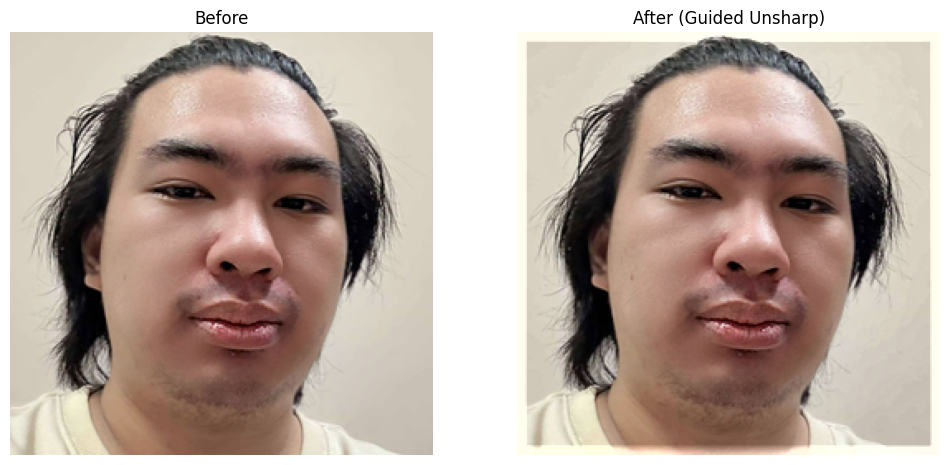

✅ 已儲存反磨皮後圖片：修圖5反_guided.png


In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ---------- [1] 設定 ----------
device = "cuda" if torch.cuda.is_available() else "cpu"

to_tensor = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

def denorm01(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

def renorm11(x01):
    return (x01 - 0.5) / 0.5

# ---------- [2] 亮度通道 ----------
def rgb_to_y(rgb01):
    r, g, b = rgb01[:,0:1], rgb01[:,1:2], rgb01[:,2:3]
    return 0.299*r + 0.587*g + 0.114*b

def replace_y(rgb01, new_y):
    r, g, b = rgb01[:,0:1], rgb01[:,1:2], rgb01[:,2:3]
    y = 0.299*r + 0.587*g + 0.114*b
    diff = new_y - y
    return torch.clamp(torch.cat([r+diff, g+diff, b+diff], dim=1), 0, 1)

# ---------- [3] 導向濾波 ----------
def box_mean(x, r):
    k = 2*r + 1
    return F.avg_pool2d(x, kernel_size=k, stride=1, padding=r)

def guided_filter(guide, src, r=8, eps=1e-4):
    mean_I  = box_mean(guide, r)
    mean_p  = box_mean(src, r)
    corr_I  = box_mean(guide*guide, r)
    corr_Ip = box_mean(guide*src, r)

    var_I = corr_I - mean_I*mean_I
    cov_Ip = corr_Ip - mean_I*mean_p

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = box_mean(a, r)
    mean_b = box_mean(b, r)
    return mean_a * guide + mean_b

# ---------- [4] 導向式反平滑 ----------
@torch.no_grad()
def guided_unsharp(rgb01, r=8, eps=1e-4, alpha=1.8):
    """
    導向式反平滑 (Guided Unsharp)
    rgb01: [B,3,H,W] in [0,1]
    """
    Y = rgb_to_y(rgb01)
    base = guided_filter(Y, Y, r=r, eps=eps)
    detail = Y - base
    Y_ref = torch.clamp(Y + alpha * detail, 0, 1)
    return replace_y(rgb01, Y_ref)

# ---------- [5] 主程式 ----------
img_path = "修圖5.png"
img = Image.open(img_path).convert("RGB")

# 轉 Tensor
img_tensor = to_tensor(img).unsqueeze(0).to(device)
img01 = denorm01(img_tensor)

# 執行導向式反平滑
with torch.no_grad():
    result01 = guided_unsharp(img01, r=6, eps=5e-5, alpha=2.3)

# ---------- [6] 顯示結果 ----------
img_np = img01[0].permute(1,2,0).cpu().numpy()
res_np = result01[0].permute(1,2,0).cpu().numpy()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("Before")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(res_np)
plt.title("After (Guided Unsharp)")
plt.axis("off")
plt.show()

# ---------- [7] 儲存結果 ----------
from torchvision.utils import save_image
save_image(renorm11(result01), "修圖5反_guided.png")
print("✅ 已儲存反磨皮後圖片：修圖5反_guided.png")


In [ ]:
img_path ="修圖5.png"   # 圖片路徑
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)


gt_path = "原圖.png"   # 圖片路徑
gt = Image.open(gt_path).convert("RGB")
gt_tensor = transform(gt).unsqueeze(0).to(device)

比較模型輸出

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
{'L1': '0.0391', 'Sobel': '0.1018', 'Laplacian': '0.0636', 'LPIPS': '0.0345', 'Res': '0.0391', 'L1_final': '0.0391', 'EvalStage1': '0.6584', 'EvalStage2': '0.9602'}


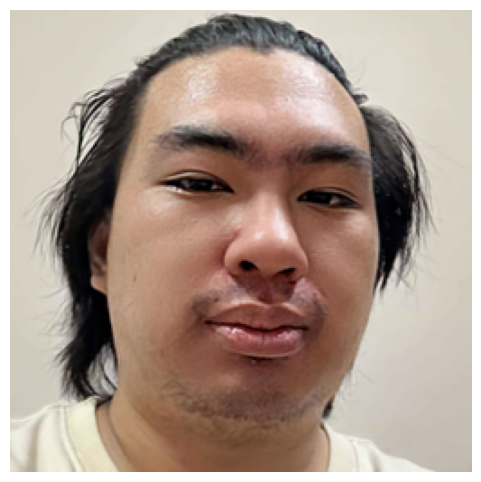

In [ ]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import lpips
# 假設都已經建好並放到 device
# criterionL1, criterionPerceptualLoss, criterionSobelEdgeLoss, criterionLaplacianEdgeLoss
# lpips_fn = lpips.LPIPS(net='alex').to(device).eval()

model1.eval(); model2.eval()
criterionL1 = nn.L1Loss().to(device)
criterionGAN = GANLoss(device, ls_gan=True).to(device)
criterionPerceptualLoss = PerceptualLoss(device, content_layers=['conv_2','conv_3']).to(device).eval()

criterionResidualLoss = ResidualLoss(nn.L1Loss()).to(device)
criterionSobelEdgeLoss = SobelEdgeLoss(mode='mag', loss='l1').to(device)
criterionLaplacianEdgeLoss = LaplacianEdgeLoss(loss='l1').to(device)
lpips_fn = lpips.LPIPS(net='alex').to(device).eval()

with torch.no_grad():
    # img_tensor, gt_tensor 皆為 (B,C,H,W)，範圍 [-1,1]
    img_tensor = img_tensor.to(device)
    gt_tensor  = gt_tensor.to(device)

    # 前向
    y_coarse = model1(img_tensor)
    y_hat, r = model2(img_tensor, y_coarse)

    # ====== 評估各種 loss（不反傳）======
    # G1 / G2 想看哪個就用相對應輸出；這裡以 y_hat 為例
    l1 = criterionL1(y_hat, gt_tensor)

    # # Perceptual（你實作的是回傳每層 list，這裡把它 sum 起來）
    # perc = sum(criterionPerceptualLoss(y_hat, gt_tensor))

    # Edge
    sobel = criterionSobelEdgeLoss(y_hat, gt_tensor)
    lap   = criterionLaplacianEdgeLoss(y_hat, gt_tensor)

    # LPIPS（輸入 [-1,1]，用 normalize=True）
    lp  = lpips_fn(y_hat, gt_tensor, normalize=True).mean()

    # 如果你也想看 residual 相關（需要 y_coarse 與 r）
    # criterionResidualLoss: 返回 (l_res, l_l1_final)
    l_res, l1_final = criterionResidualLoss(r, y_hat, gt_tensor, y_coarse)

    # 你訓練時的加權總和（當成一個評估指標）
    eval_score_stage1 = 10.0*l1 + 2.0*sobel + 1.0*lap
    eval_score_stage2 = 1.0*lp + 5.0*l1_final + 5.0*l_res + 4.0*(sobel+0.5*lap)
    # （GAN/FMR 在推論沒有對手可比，通常不在 inference 計）

    print({
      "L1": f"{l1:.4f}",
      "Sobel": f"{sobel:.4f}",
      "Laplacian": f"{lap:.4f}",
      "LPIPS": f"{lp:.4f}",
      "Res": f"{l_res:.4f}",
      "L1_final": f"{l1_final:.4f}",
      "EvalStage1": f"{eval_score_stage1:.4f}",
      "EvalStage2": f"{eval_score_stage2:.4f}"
    })


# ====== 視覺化輸出 ======
vis = y_hat.detach().cpu()
if vis.dim() == 4:
    vis = vis[0]
vis = (vis * 0.5 + 0.5).clamp(0, 1)

to_pil = transforms.ToPILImage()
out_img = to_pil(vis)
plt.figure(figsize=(6,6)); plt.imshow(out_img); plt.axis('off'); plt.show()
out_img.save("復原f1.png")


比較修圖

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
{'L1': '0.0523', 'Sobel': '0.0906', 'Laplacian': '0.0444', 'LPIPS': '0.0309', 'Res': '0.0379', 'L1_final': '0.0523', 'EvalStage1': '0.7485', 'EvalStage2': '0.9329'}


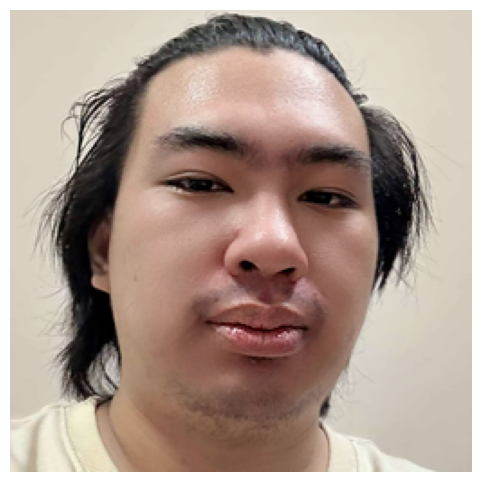

In [ ]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import lpips

criterionL1 = nn.L1Loss().to(device)
criterionGAN = GANLoss(device, ls_gan=True).to(device)
criterionPerceptualLoss = PerceptualLoss(device, content_layers=['conv_2','conv_3']).to(device).eval()

criterionResidualLoss = ResidualLoss(nn.L1Loss()).to(device)
criterionSobelEdgeLoss = SobelEdgeLoss(mode='mag', loss='l1').to(device)
criterionLaplacianEdgeLoss = LaplacianEdgeLoss(loss='l1').to(device)
lpips_fn = lpips.LPIPS(net='alex').to(device).eval()

with torch.no_grad():
    # img_tensor, gt_tensor 皆為 (B,C,H,W)，範圍 [-1,1]
    y_hat = img_tensor.to(device)
    gt_tensor  = gt_tensor.to(device)


    # ====== 評估各種 loss（不反傳）======
    # G1 / G2 想看哪個就用相對應輸出；這裡以 y_hat 為例
    l1 = criterionL1(y_hat, gt_tensor)

    # # Perceptual（你實作的是回傳每層 list，這裡把它 sum 起來）
    # perc = sum(criterionPerceptualLoss(y_hat, gt_tensor))

    # Edge
    sobel = criterionSobelEdgeLoss(y_hat, gt_tensor)
    lap   = criterionLaplacianEdgeLoss(y_hat, gt_tensor)

    # LPIPS（輸入 [-1,1]，用 normalize=True）
    lp  = lpips_fn(y_hat, gt_tensor, normalize=True).mean()

    # 如果你也想看 residual 相關（需要 y_coarse 與 r）
    # criterionResidualLoss: 返回 (l_res, l_l1_final)
    l_res, l1_final = criterionResidualLoss(r, y_hat, gt_tensor, y_coarse)

    # 你訓練時的加權總和（當成一個評估指標）
    eval_score_stage1 = 10.0*l1 + 2.0*sobel + 1.0*lap
    eval_score_stage2 = 1.0*lp + 5.0*l1_final + 5.0*l_res + 4.0*(sobel+0.5*lap)
    # （GAN/FMR 在推論沒有對手可比，通常不在 inference 計）

    print({
      "L1": f"{l1:.4f}",
      "Sobel": f"{sobel:.4f}",
      "Laplacian": f"{lap:.4f}",
      "LPIPS": f"{lp:.4f}",
      "Res": f"{l_res:.4f}",
      "L1_final": f"{l1_final:.4f}",
      "EvalStage1": f"{eval_score_stage1:.4f}",
      "EvalStage2": f"{eval_score_stage2:.4f}"
    })


# ====== 視覺化輸出 ======
vis = y_hat.detach().cpu()
if vis.dim() == 4:
    vis = vis[0]
vis = (vis * 0.5 + 0.5).clamp(0, 1)

to_pil = transforms.ToPILImage()
out_img = to_pil(vis)
plt.figure(figsize=(6,6)); plt.imshow(out_img); plt.axis('off'); plt.show()
out_img.save("復原f1.png")


4種反模糊
1. 導向 + 針對皮膚
2. 高森 + 針對皮膚
3. 導向
4. 高森


In [ ]:
!git clone https://github.com/zllrunning/face-parsing.PyTorch.git


Cloning into 'face-parsing.PyTorch'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 92 (delta 21), reused 17 (delta 17), pack-reused 63 (from 1)
Receiving objects: 100% (92/92), 3.06 MiB | 7.17 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [ ]:
import sys
sys.path.append("face-parsing.PyTorch")   # ✅ 這行一定要有
from model import BiSeNet


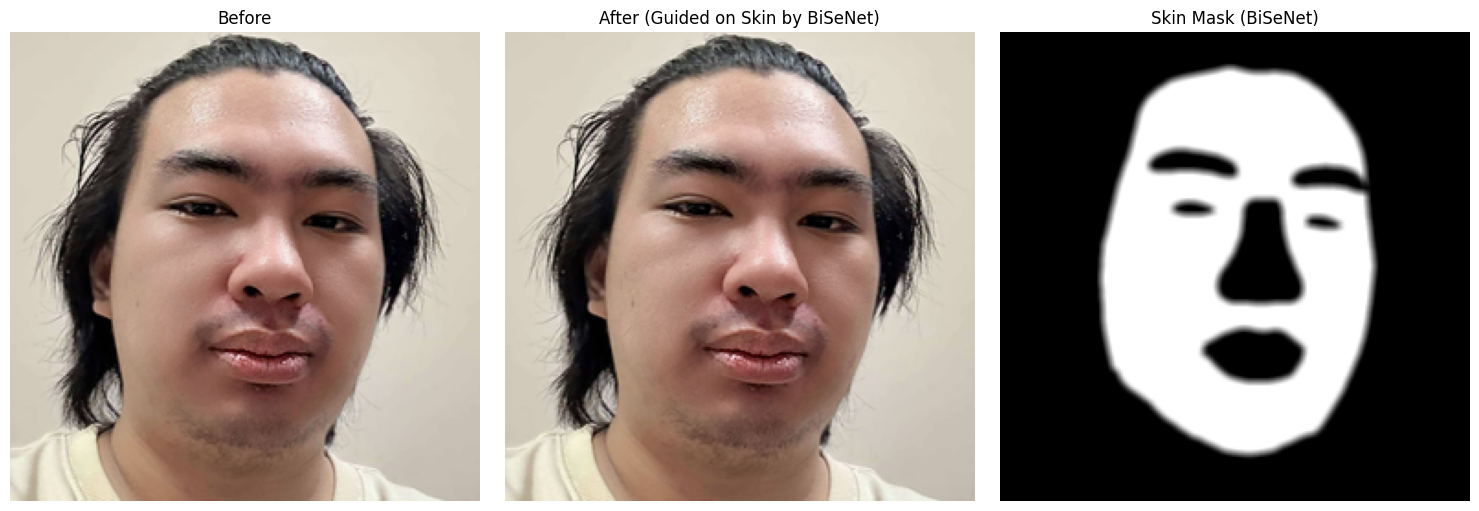

✅ 已儲存：修圖5反_guided_skin_bisenet.png ；比較圖：guided_skin_bisenet_compare.png


In [ ]:
import sys, torch, torch.nn.functional as F
from pathlib import Path
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ========== [0] 路徑設定：改成你的實際位置 ==========
device = "cuda" if torch.cuda.is_available() else "cpu"
REPO_DIR = Path("face-parsing.PyTorch")  # <- 改成你的 clone 路徑
WEIGHT_FILE = Path("79999_iter.pth")

# 加入 repo 到 sys.path
repo_path = str(REPO_DIR.resolve())
if repo_path not in sys.path:
    sys.path.append(repo_path)

# ========== [1] 匯入 BiSeNet 並載入權重 ==========
from model import BiSeNet

def load_face_parser(device, weight_path):
    net = BiSeNet(n_classes=19)
    state = torch.load(str(weight_path), map_location=device)
    net.load_state_dict(state)
    net.eval().to(device)
    return net

parser = load_face_parser(device, WEIGHT_FILE)

# ========== [2] 基本 I/O ==========
to_tensor = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # -> [-1,1]
])

def denorm01(x):      # [-1,1] -> [0,1]
    return (x * 0.5 + 0.5).clamp(0, 1)

def renorm11(x01):    # [0,1] -> [-1,1]
    return (x01 - 0.5) / 0.5

# ========== [3] 導向濾波 + 亮度處理 ==========
def rgb_to_y(rgb01):
    r, g, b = rgb01[:,0:1], rgb01[:,1:2], rgb01[:,2:3]
    return 0.299*r + 0.587*g + 0.114*b

def replace_y(rgb01, new_y):
    r, g, b = rgb01[:,0:1], rgb01[:,1:2], rgb01[:,2:3]
    y = 0.299*r + 0.587*g + 0.114*b
    diff = new_y - y
    return torch.clamp(torch.cat([r+diff, g+diff, b+diff], dim=1), 0, 1)

def box_mean(x, r):
    k = 2*r + 1
    return F.avg_pool2d(x, kernel_size=k, stride=1, padding=r)

def guided_filter(guide, src, r=8, eps=1e-4):
    mean_I  = box_mean(guide, r)
    mean_p  = box_mean(src, r)
    corr_I  = box_mean(guide*guide, r)
    corr_Ip = box_mean(guide*src, r)
    var_I = corr_I - mean_I*mean_I
    cov_Ip = corr_Ip - mean_I*mean_p
    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I
    mean_a = box_mean(a, r)
    mean_b = box_mean(b, r)
    return mean_a * guide + mean_b

@torch.no_grad()
def guided_unsharp(rgb01, r=8, eps=1e-4, alpha=1.8):
    Y = rgb_to_y(rgb01)
    base = guided_filter(Y, Y, r=r, eps=eps)
    detail = Y - base
    Y_ref = torch.clamp(Y + alpha * detail, 0, 1)
    return replace_y(rgb01, Y_ref)

# ========== [4] BiSeNet 皮膚遮罩 ==========
@torch.no_grad()
def get_skin_mask(parser, img01):  # img01: [B,3,H,W] in [0,1]
    resize = T.Resize((512, 512))
    ir = resize(img01)
    logits = parser(ir)[0]                    # [B,19,512,512]
    parsing = logits.argmax(1, keepdim=True)  # [B,1,512,512]
    mask = (parsing == 1).float()             # class=1 = skin
    mask = F.interpolate(mask, size=img01.shape[-2:], mode='bilinear', align_corners=False)
    mask = F.avg_pool2d(mask, 5, 1, 2)        # 邊界柔化
    return mask.clamp(0, 1)                   # [B,1,H,W]

# ========== [5] 僅皮膚導向式反平滑 ==========
@torch.no_grad()
def guided_unsharp_on_skin_bisenet(img_tensor, parser, r=6, eps=5e-5, alpha=2.3):
    """
    img_tensor: [-1,1], [B,3,H,W]
    回傳: result_tensor[-1,1], mask[0..1]
    """
    img01 = denorm01(img_tensor)                 # -> [0,1]
    mask  = get_skin_mask(parser, img01)         # [B,1,H,W]
    enh   = guided_unsharp(img01, r=r, eps=eps, alpha=alpha)
    out01 = img01 * (1 - mask) + enh * mask      # 只在皮膚區域替換
    return renorm11(out01), mask

# ========== [6] Demo：讀圖→只在皮膚反平滑→並排顯示 ==========
img_path = "修圖5.png"   # 改成你的路徑
img = Image.open(img_path).convert("RGB")

x = to_tensor(img).unsqueeze(0).to(device)  # [-1,1]
with torch.no_grad():
    y, mask = guided_unsharp_on_skin_bisenet(x, parser, r=6, eps=5e-5, alpha=2.3)

# 視覺化（Before / After / Mask）
src = denorm01(x)[0].permute(1,2,0).cpu().numpy()
dst = denorm01(y)[0].permute(1,2,0).cpu().numpy()
msk = mask[0,0].cpu().numpy()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(src); plt.title("Before"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(dst); plt.title("After (Guided on Skin by BiSeNet)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(msk, cmap="gray"); plt.title("Skin Mask (BiSeNet)"); plt.axis("off")
plt.tight_layout(); plt.savefig("guided_skin_bisenet_compare.png", dpi=150); plt.show()

# 輸出結果圖（[-1,1] -> 檔案）
from torchvision.utils import save_image
save_image(y, "修圖5反_guided_skin_bisenet.png")
print("✅ 已儲存：修圖5反_guided_skin_bisenet.png ；比較圖：guided_skin_bisenet_compare.png")


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


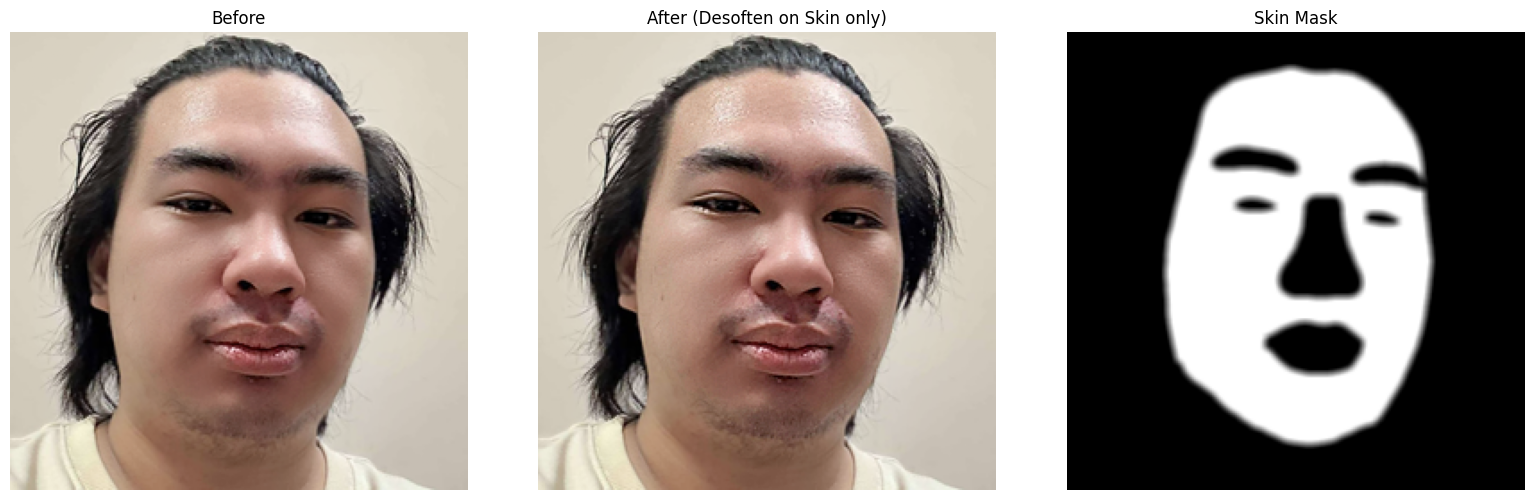

✅ 已儲存：修圖5反_onlySkin.png


In [ ]:
import sys, torch, torch.nn.functional as F
from pathlib import Path
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ---------- [0] 設備 ----------
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- [0.1] BiSeNet 專案與權重路徑（請依環境調整） ----------
REPO_DIR = Path("face-parsing.PyTorch")   # 你的 clone 路徑
WEIGHT_FILE = Path("79999_iter.pth")      # 權重檔（可放同工作目錄）
repo_path = str(REPO_DIR.resolve())
if repo_path not in sys.path:
    sys.path.append(repo_path)

# ---------- [0.2] 匯入 BiSeNet 並載入 ----------
from model import BiSeNet

def load_face_parser(device, weight_path):
    net = BiSeNet(n_classes=19)
    state = torch.load(str(weight_path), map_location=device)
    net.load_state_dict(state)
    net.eval().to(device)
    return net

parser = load_face_parser(device, WEIGHT_FILE)

# ---------- [1] 轉換 ----------
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # -> [-1,1]
])

def denormalize(t):  # [-1,1] -> [0,1]
    return (t * 0.5 + 0.5).clamp(0, 1)

def renormalize01_to_11(t01):  # [0,1] -> [-1,1]
    return (t01 - 0.5) / 0.5

# ---------- [2] 讀圖 ----------
img_path = "修圖5.png"
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)  # [-1,1]
img01 = denormalize(img_tensor)                      # [0,1]（給 BiSeNet 用）

# ---------- [3] 你的 Gaussian blur（手動版，保留） ----------
def gaussian_kernel(kernel_size=5, sigma=1.0, channels=3):
    x_coord = torch.arange(kernel_size, device=img_tensor.device, dtype=torch.float32)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1) / 2.
    variance = sigma ** 2.

    gk = (1./(2.*torch.pi*variance)) * torch.exp(-torch.sum((xy_grid - mean) ** 2., dim=-1) / (2*variance))
    gk = gk / gk.sum()
    gk = gk.view(1, 1, kernel_size, kernel_size)
    gk = gk.repeat(channels, 1, 1, 1)
    return gk

def gaussian_blur_torch(x, sigma=1.0):
    kernel_size = int(2 * round(3 * sigma) + 1)
    kernel = gaussian_kernel(kernel_size, sigma, x.size(1)).to(x.device)
    padding = kernel_size // 2
    x_blur = F.conv2d(x, kernel, padding=padding, groups=x.size(1))
    return x_blur

def desoften(img, alpha=0.3, steps=5, sigma=0.7):
    I = img.clone()
    for _ in range(steps):
        I_blur = gaussian_blur_torch(I, sigma)
        I = img + alpha * (img - I_blur)
        I = torch.clamp(I, -1, 1)
    return I

def desoften_sharpen(img, alpha=0.7, steps=10, sigma=1.5, sharpness=0.5):
    I = img.clone()
    for _ in range(steps):
        I_blur = gaussian_blur_torch(I, sigma)
        I = img + alpha * (img - I_blur)
        I = torch.clamp(I, -1, 1)
    I_blur2 = gaussian_blur_torch(I, sigma=1.0)
    I = torch.clamp(I + sharpness * (I - I_blur2), -1, 1)
    return I

# ---------- [4] BiSeNet 皮膚遮罩（class=1=skin） ----------
@torch.no_grad()
def get_skin_mask(parser, img01):  # img01: [B,3,H,W] in [0,1]
    resize = T.Resize((512, 512))
    ir = resize(img01)
    logits = parser(ir)[0]                    # [B,19,512,512]
    parsing = logits.argmax(1, keepdim=True)  # [B,1,512,512]
    mask = (parsing == 1).float()             # skin
    mask = F.interpolate(mask, size=img01.shape[-2:], mode='bilinear', align_corners=False)
    # 邊界柔化，避免硬切
    mask = F.avg_pool2d(mask, kernel_size=5, stride=1, padding=2)
    return mask.clamp(0, 1)                   # [B,1,H,W]

with torch.no_grad():
    skin_mask = get_skin_mask(parser, img01)                  # [0,1]
    skin_mask_3c = skin_mask.expand(-1, 3, -1, -1)            # [B,3,H,W] 方便相乘

# ---------- [5] 只在皮膚區域套用「你的 desoften」 ----------
with torch.no_grad():
    result_full = desoften(img_tensor, alpha=0.6, steps=10, sigma=1.5)      # 你的原流程（全圖）
    # 融合：非皮膚=原圖，皮膚=反模糊
    result_skin = img_tensor * (1 - skin_mask_3c) + result_full * skin_mask_3c

# ---------- [6] 視覺化 ----------
src_np = img01[0].permute(1,2,0).cpu().numpy()
res_np = denormalize(result_skin)[0].permute(1,2,0).cpu().numpy()
msk_np = skin_mask[0,0].cpu().numpy()

plt.figure(figsize=(16,5))
plt.subplot(1,3,1); plt.imshow(src_np); plt.title("Before"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(res_np); plt.title("After (Desoften on Skin only)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(msk_np, cmap='gray'); plt.title("Skin Mask"); plt.axis("off")
plt.tight_layout(); plt.show()

# ---------- [7] 儲存 ----------
from torchvision.utils import save_image
save_image(denormalize(result_skin), "修圖5反_onlySkin.png")
print("✅ 已儲存：修圖5反_onlySkin.png")


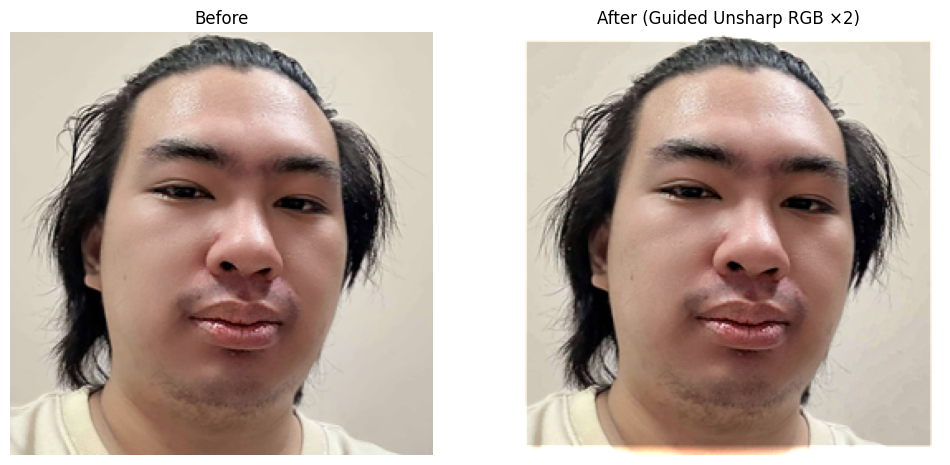

✅ 已儲存：修圖5反_guided_rgb_iter.png


In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ---------- [1] 設定 ----------
device = "cuda" if torch.cuda.is_available() else "cpu"

to_tensor = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

def denorm01(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

def renorm11(x01):
    return (x01 - 0.5) / 0.5

# ---------- [3] 導向濾波 ----------
def box_mean(x, r):
    k = 2*r + 1
    return F.avg_pool2d(x, kernel_size=k, stride=1, padding=r)

def guided_filter(guide, src, r=8, eps=1e-4):
    mean_I  = box_mean(guide, r)
    mean_p  = box_mean(src, r)
    corr_I  = box_mean(guide*guide, r)
    corr_Ip = box_mean(guide*src, r)

    var_I = corr_I - mean_I*mean_I
    cov_Ip = corr_Ip - mean_I*mean_p

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = box_mean(a, r)
    mean_b = box_mean(b, r)
    return mean_a * guide + mean_b

# ---------- [4] 導向式反平滑（RGB 版，可多次迭代；不使用亮度通道） ----------
@torch.no_grad()
def guided_unsharp_rgb_iter(rgb01, r=8, eps=1e-4, alpha=1.8, iters=2):
    """
    直接對 RGB 三通道各自做導向濾波與反平滑。
    - rgb01: [B,3,H,W] in [0,1]
    - iters: 重複次數（建議 1~3）
    備註：為避免一次過強，將每步強度設為 alpha/iters。
    """
    I = rgb01.clone()
    step_alpha = float(alpha) / max(int(iters), 1)
    for _ in range(int(iters)):
        base_r = guided_filter(I[:,0:1], I[:,0:1], r=r, eps=eps)
        base_g = guided_filter(I[:,1:2], I[:,1:2], r=r, eps=eps)
        base_b = guided_filter(I[:,2:3], I[:,2:3], r=r, eps=eps)
        base = torch.cat([base_r, base_g, base_b], dim=1)  # [B,3,H,W]
        detail = I - base
        I = torch.clamp(I + step_alpha * detail, 0, 1)
    return I

# ---------- [5] 主程式 ----------
img_path = "修圖5.png"
img = Image.open(img_path).convert("RGB")

# 轉 Tensor
img_tensor = to_tensor(img).unsqueeze(0).to(device)  # [-1,1]
img01 = denorm01(img_tensor)                         # [0,1]

# 執行「RGB 版、可多次」導向式反平滑（不使用亮度通道）
with torch.no_grad():
    result01 = guided_unsharp_rgb_iter(img01, r=6, eps=5e-5, alpha=2.3, iters=2)

# ---------- [6] 顯示結果 ----------
img_np = img01[0].permute(1,2,0).cpu().numpy()
res_np = result01[0].permute(1,2,0).cpu().numpy()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("Before")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(res_np)
plt.title("After (Guided Unsharp RGB ×2)")
plt.axis("off")
plt.show()

# ---------- [7] 儲存結果 ----------
from torchvision.utils import save_image
save_image(result01, "修圖5反_guided_rgb_iter.png")
print("✅ 已儲存：修圖5反_guided_rgb_iter.png")


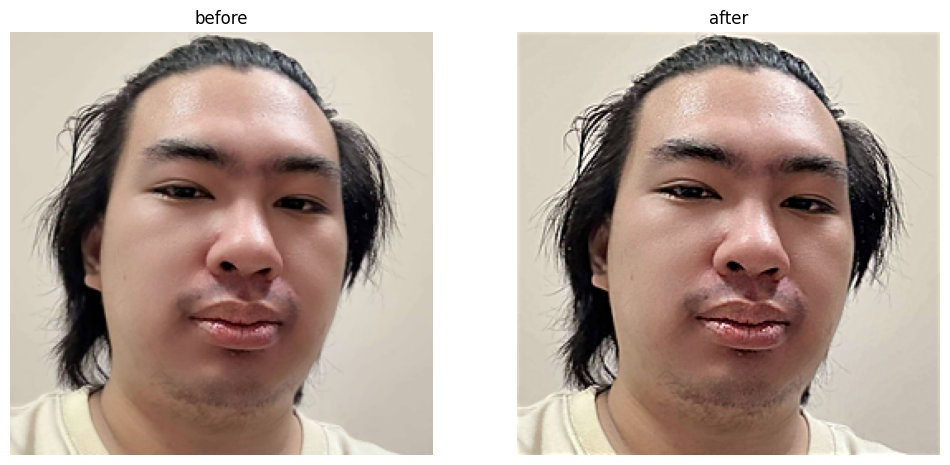

✅ 已儲存反磨皮後圖片：反磨皮結果.png


In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ---------- [1] 轉換與設備設定 ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# ---------- [2] 讀取圖片 ----------
img_path = "修圖5.png"
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

# ---------- [3] 定義 Gaussian blur（手動版） ----------
def gaussian_kernel(kernel_size=5, sigma=1.0, channels=3):
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1) / 2.
    variance = sigma ** 2.

    gaussian_kernel = (1./(2.*torch.pi*variance)) * \
        torch.exp(-torch.sum((xy_grid - mean) ** 2., dim=-1) / (2*variance))

    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)
    return gaussian_kernel

def gaussian_blur_torch(x, sigma=1.0):
    kernel_size = int(2 * round(3 * sigma) + 1)
    kernel = gaussian_kernel(kernel_size, sigma, x.size(1)).to(x.device)
    padding = kernel_size // 2
    x_blur = F.conv2d(x, kernel, padding=padding, groups=x.size(1))
    return x_blur

def desoften_sharpen(img, alpha=0.7, steps=10, sigma=1.5, sharpness=0.5):
    I = img.clone()
    for _ in range(steps):
        I_blur = gaussian_blur_torch(I, sigma)
        I = img + alpha * (img - I_blur)
        I = torch.clamp(I, -1, 1)
    # 再加一層 Unsharp Mask 銳化
    I_blur2 = gaussian_blur_torch(I, sigma=1.0)
    I = torch.clamp(I + sharpness * (I - I_blur2), -1, 1)
    return I

def desoften(img, alpha=0.3, steps=5, sigma=0.7):
    I = img.clone()
    for _ in range(steps):
        I_blur = gaussian_blur_torch(I, sigma)
        I = img + alpha * (img - I_blur)
        I = torch.clamp(I, -1, 1)
    return I

# ---------- [4] 執行反磨皮 ----------
with torch.no_grad():
    result = desoften(img_tensor, alpha=0.6, steps=10, sigma=1.5)
# with torch.no_grad():
#     result = desoften_sharpen(img_tensor, alpha=0.6, steps=10, sigma=1.5, sharpness=0.5)

# ---------- [5] 還原成可視化圖片 ----------
def denormalize(t):
    t = (t * 0.5 + 0.5).clamp(0, 1)
    return t

img_np = denormalize(img_tensor[0]).permute(1,2,0).cpu().numpy()
res_np = denormalize(result[0]).permute(1,2,0).cpu().numpy()

# ---------- [6] 顯示比較 ----------
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("before")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(res_np)
plt.title("after")
plt.axis("off")
plt.show()

# ---------- [7] 儲存圖片 ----------
from torchvision.utils import save_image
save_image(denormalize(result), "修圖5反.png")

print("✅ 已儲存反磨皮後圖片：反磨皮結果.png")
